## Read in Prepared (Cleaned) Data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Read in data
df = pd.read_pickle('data.pkl')

# read in the graph
citation_network = nx.read_gexf("Cleaned Data and Graph/citation_network.gexf")
print("Citation network number_of_nodes", citation_network.number_of_nodes())
print("Citation network number_of_edges", citation_network.number_of_edges())


Citation network number_of_nodes 629814
Citation network number_of_edges 632751


In [2]:
print("Columns of the stored data frame:", df.columns)
print("df.shape",df.shape)
print("Number of non empty references papers:", sum(x != '[]' for x in df.loc[:]['references']))


Columns of the stored data frame: Index(['title', 'authors', 'year', 'venue', 'index_id', 'references',
       'abstract'],
      dtype='object')
df.shape (629814, 7)
Number of non empty references papers: 125372


### Citation Network Exploration and Visualization

[('629811', '294663')]


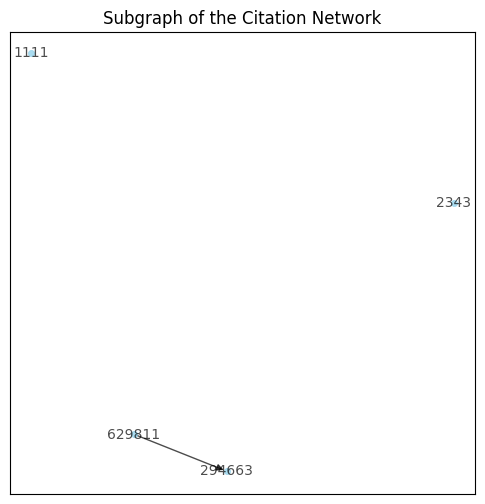

In [4]:
def int_to_string(list_of_int):
    """Convert a list of int to string"""
    return [str(x) for x in list_of_int]


def subgraph_visualization(G, list_of_nodes):
    """Visualize subgraph of a graph G by specifying subgraph nodes"""
    H = G.subgraph(list_of_nodes)
    print(H.edges())
    
    plt.figure(figsize=(6,6))
    nx.draw_networkx(H, with_labels=True, node_size=20, font_size=10, node_color="skyblue", alpha=0.7, linewidths=0.5)
    plt.title("Subgraph of the Citation Network")
    plt.show()
    
subgraph_visualization(citation_network, int_to_string([629811, 294663, 1111, 2343]))

        

In [5]:
def find_citations(graph, node_label):
    """
    Find all papers a given paper cites and all papers that cite it.

    :param graph: The citation network graph.
    :param node_label: The label of the node (paper) in question.
    :return: A tuple of two lists: (cited_by, cites)
    """
    if node_label not in graph:
        return [], []

    # Papers that the given paper cites
    cites = [n for n in graph.successors(node_label)]

    # Papers that cite the given paper
    cited_by = [n for n in graph.predecessors(node_label)]

    return cited_by, cites

# Example 
node_label = '629811'  # Replace with the actual node label you are interested in
cited_by, cites = find_citations(citation_network, node_label)
print(f"Papers cited by paper {node_label}: {cites}")
print(f"Papers that cite paper {node_label}: {cited_by}")


Papers cited by paper 629811: ['294663', '302639', '572828']
Papers that cite paper 629811: []


## Author (Collaborator) Network

In [2]:
# Read in author network
author_network = nx.read_gexf("Cleaned Data and Graph/author_network.gexf")
print("number_of_nodes", author_network.number_of_nodes())
print("number_of_edges", author_network.number_of_edges())


number_of_nodes 505027
number_of_edges 1137185


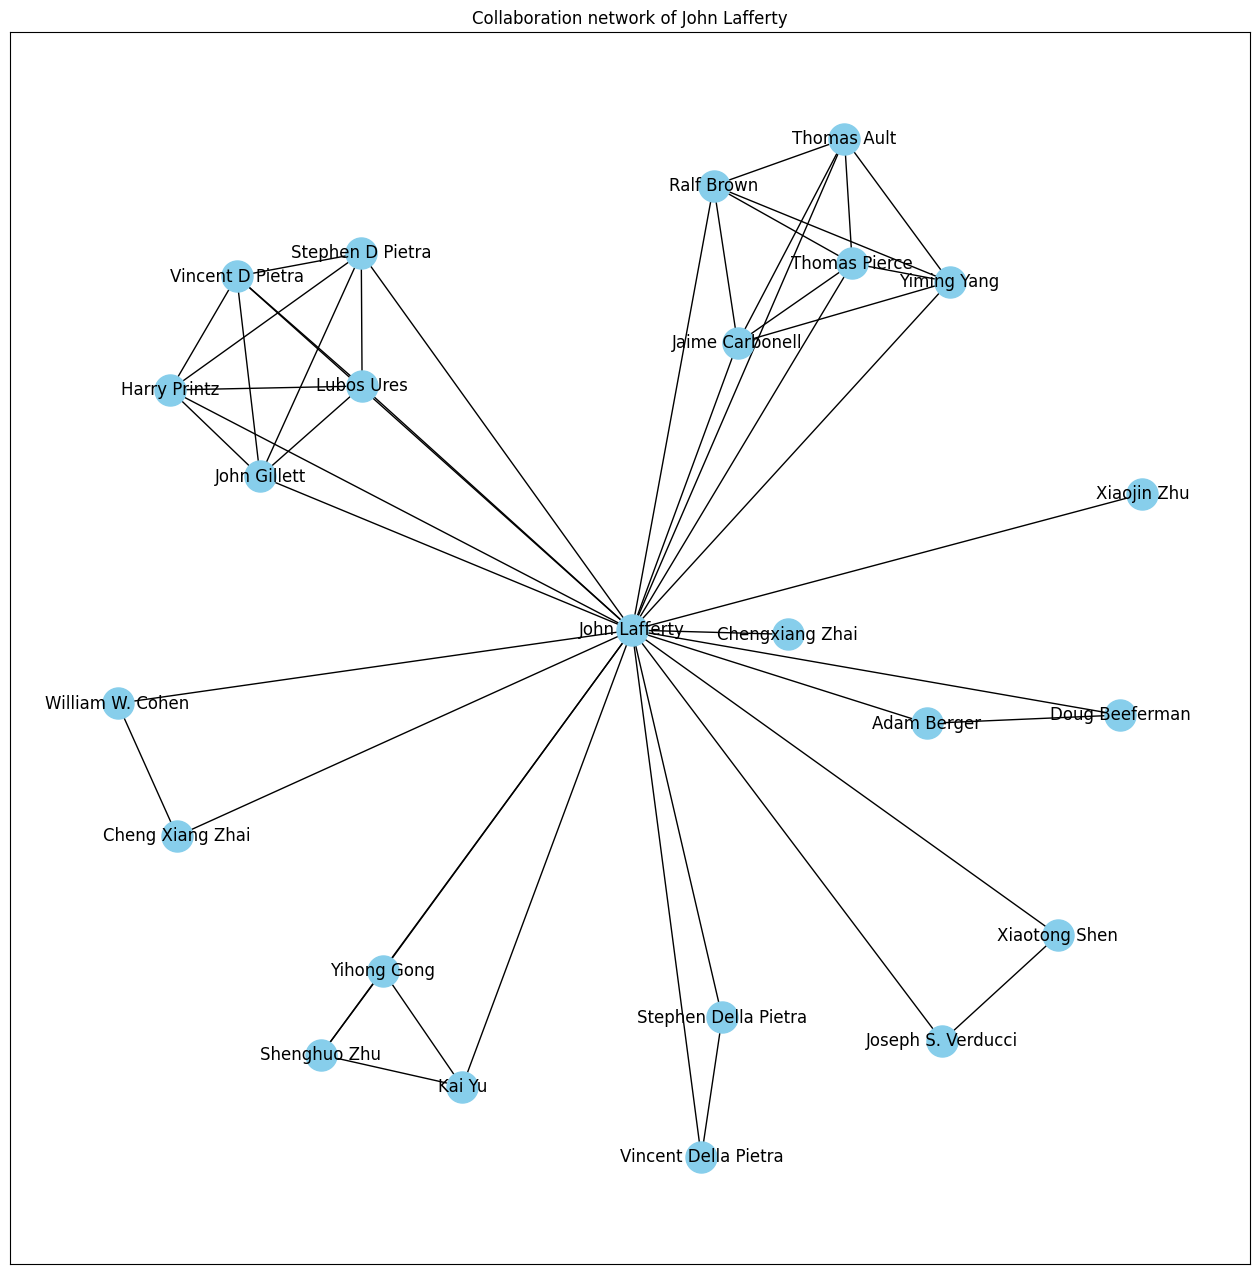

In [7]:
from fuzzywuzzy import process

all_authors = set(author.lower() for sublist in df['authors'] for author in sublist)

def find_similar_names(name, all_authors, top_n=1):
    """
    Find similar author names, ignoring capitalization.
    Return only the exact match if found, otherwise return the top similar name.

    name: The name to compare to.
    all_authors: Set of all author names.
    top_n: The number of top similar names to return (default is 1).
    return The most similar name or the exact name.
    """
    normalized_name = name.lower()
    similar_names = process.extract(normalized_name, all_authors, limit=top_n)
    return [name for name, score in similar_names]

def get_collaborators(graph, author_name, visualize=False, visualize_node_size = 5000, fig_size=(12,12)):
    """
    Get the collaborators of a given author and optionally visualize their network.
    If the exact author name is not found, use similar names.

    graph: The author network graph.
    author_name: The name of the author.
    visualize: Boolean to indicate whether to visualize the network.
    return: A list of collaborators.
    """
    all_authors = set(graph.nodes())
    collaborators = []

    # Check if the author is in the graph, otherwise find the closest match
    if author_name not in all_authors:
        similar_names = find_similar_names(author_name, all_authors, top_n=1)
        if similar_names:
            author_name = similar_names[0]  # Take the most similar name
        else:
            return []

    collaborators = list(graph.neighbors(author_name))

    if visualize:
        # Create a subgraph for the author and their collaborators
        subgraph_nodes = [author_name] + collaborators
        subgraph = graph.subgraph(subgraph_nodes)

        # Visualize the subgraph
        plt.figure(figsize=fig_size)
        pos = nx.spring_layout(subgraph)
        nx.draw_networkx(subgraph, pos, node_size=500, node_color="skyblue", with_labels=True)
        plt.title(f"Collaboration network of {author_name}")
        plt.savefig(f"visualizations/{author_name}_collaboration_network.png")
        plt.show()


    return collaborators

# Example
author_name = 'John Lafferty'  
collaborators = get_collaborators(author_network, author_name, visualize=True, fig_size = (16,16))



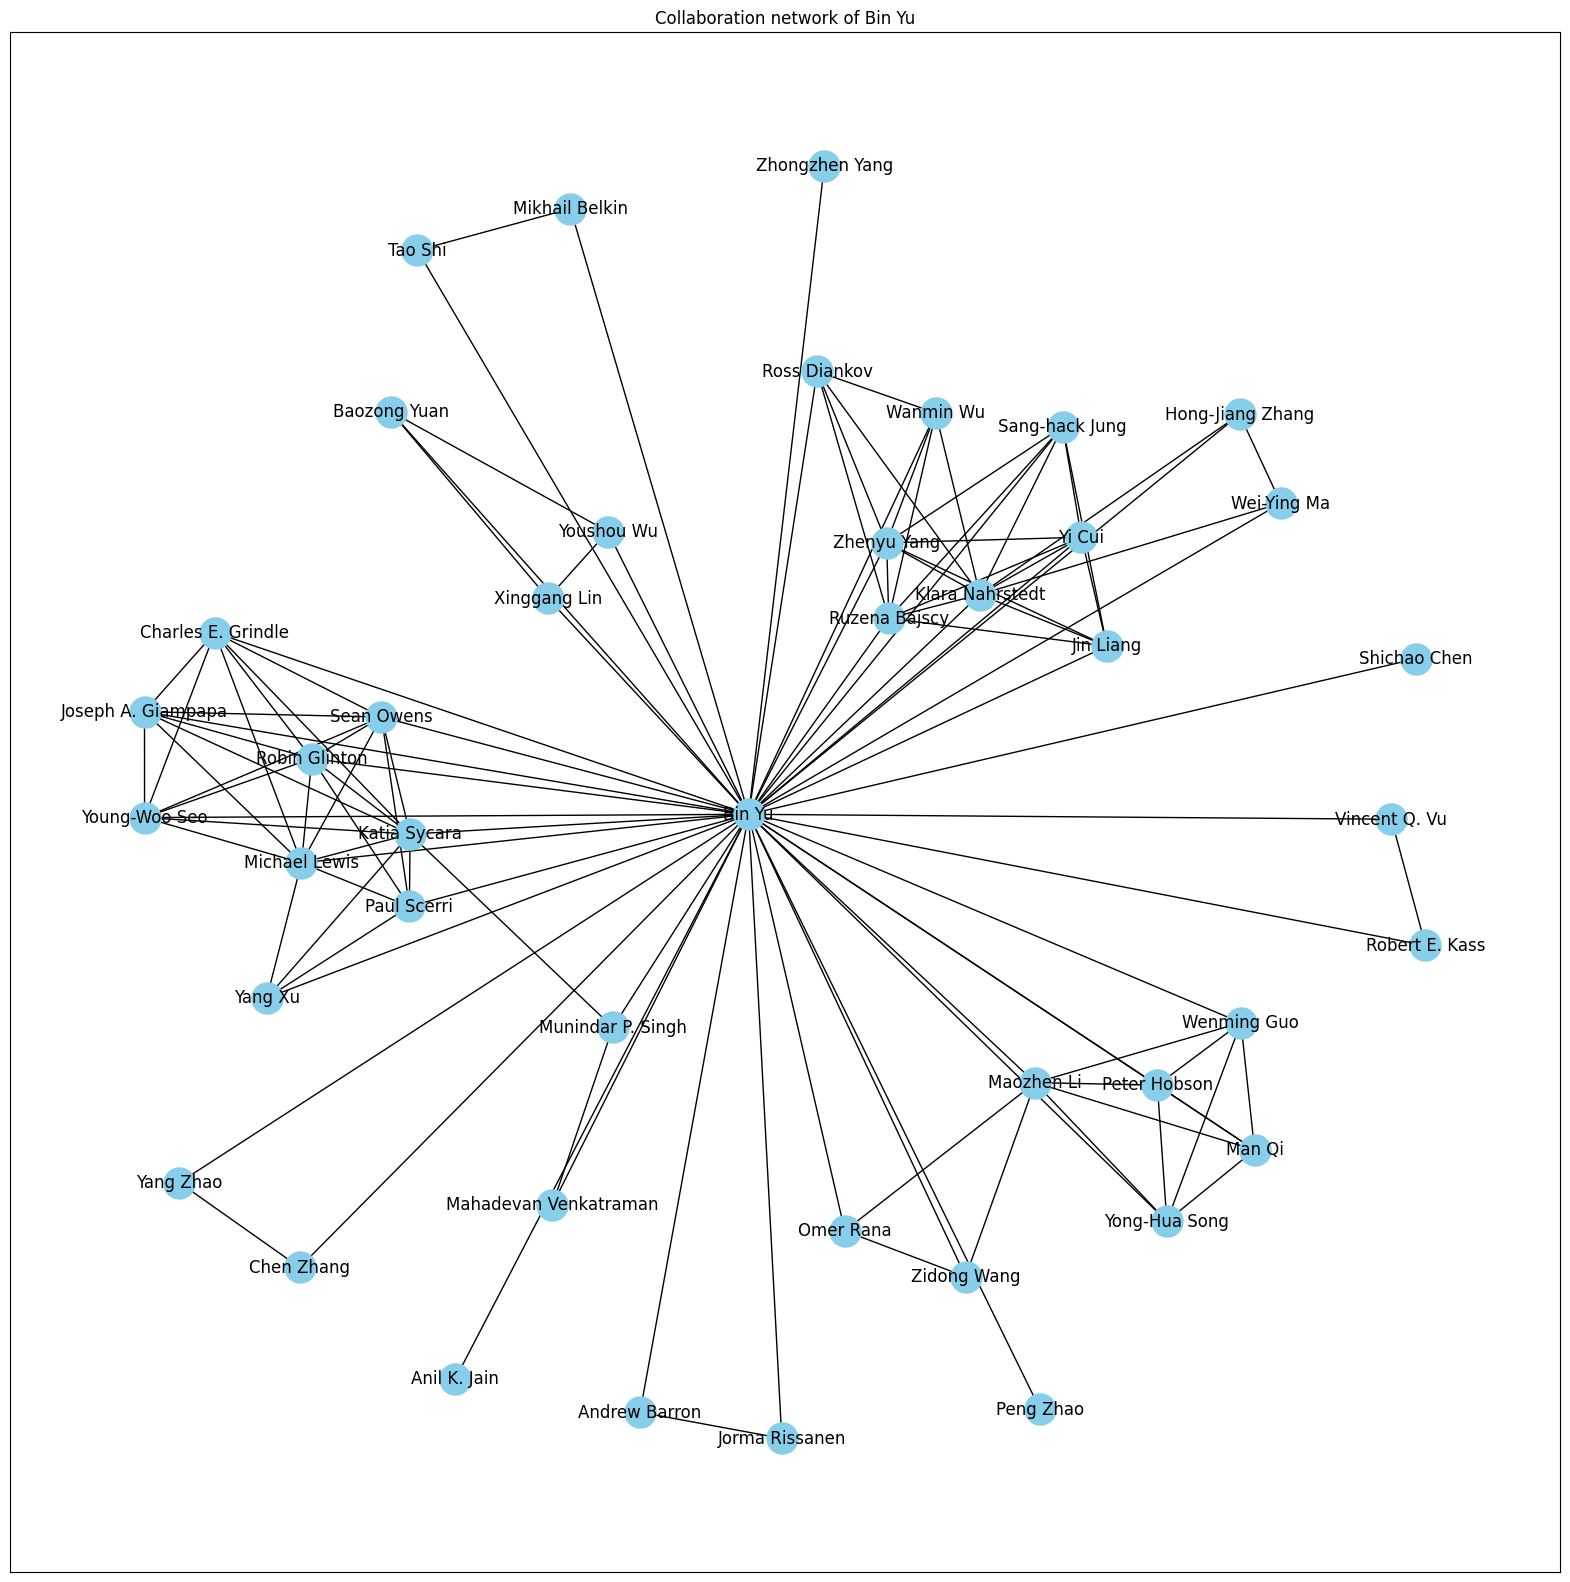

In [9]:
collaborators = get_collaborators(author_network, "Bin Yu", visualize=True, visualize_node_size=2000,fig_size = (20,20))


### Community Detection

In [ ]:

import community as community_louvain

def cluster_authors_network(graph):
    # Use the Louvain method for community detection
    partition = community_louvain.best_partition(graph)
    return partition

# Clustering the author network
author_partition = cluster_authors_network(author_network)

# Store the author network
import json
with open('Results/partition.json', 'w') as f:
    json.dump(author_partition, f)


In [5]:
# Reading the partition from the JSON file I stored
import json
import ast

with open('Results/partition.json', 'r') as f:
    author_partition = json.load(f)


In [10]:

def extract_papers_for_clusters(df, partition):
    """store paper cluster information based on author clustering"""
    
    cluster_papers = {cluster: [] for cluster in set(partition.values())}
    cluster_papers_title = {cluster: [] for cluster in set(partition.values())}
    
    
    for row in range(df.shape[0]):
        paper_authors = df.loc[row]['authors']
        paper_title = df.loc[row]['title']
        paper_abstract = df.loc[row]['abstract']
        # Determine the cluster of the paper based on its authors
        for author in ast.literal_eval(paper_authors):
            author_cluster = partition.get(author)  
            if author_cluster is not None:
                cluster_papers[author_cluster].append((paper_title + " " + str(paper_abstract)) if (str(paper_abstract) != 'nan') else paper_title) # concatenate title and abstract for further nlp analysis
                cluster_papers_title[author_cluster].append(paper_title)
    return {k:list(set(v)) for k,v in cluster_papers.items()}, cluster_papers_title  # remove duplicates in paper title+abstract

cluster_papers, cluster_papers_title = extract_papers_for_clusters(df, author_partition)


In [11]:
# Saving the partition as a JSON file
with open('Results/cluster_paper.json', 'w') as f:
    json.dump(cluster_papers, f)
    
with open('Results/cluster_paper_title_only.json', 'w') as f:
    json.dump(cluster_papers_title, f)

In [4]:
# Reading the paper clustering from a JSON file
import json
with open('Results/cluster_paper.json', 'r') as f:
    cluster_papers = json.load(f)
    
with open('Results/cluster_paper_title_only.json', 'r') as f:
    cluster_papers_title = json.load(f)

In [13]:
# cluster information of clusters over size 5000
print("Number of clusters:", len(list(cluster_papers.keys())))
for k,v in cluster_papers.items():
    if len(v) > 5000:
        print(f"Number of papers in cluster {k}:", len(v))

Number of clusters: 52505
Number of papers in cluster 1: 5493
Number of papers in cluster 4: 18325
Number of papers in cluster 7: 32098
Number of papers in cluster 9: 7728
Number of papers in cluster 10: 6921
Number of papers in cluster 25: 7993
Number of papers in cluster 28: 13710
Number of papers in cluster 29: 5103
Number of papers in cluster 31: 15936
Number of papers in cluster 43: 5351
Number of papers in cluster 51: 12773
Number of papers in cluster 62: 9111
Number of papers in cluster 70: 5732
Number of papers in cluster 72: 13775
Number of papers in cluster 88: 10244
Number of papers in cluster 100: 5626
Number of papers in cluster 109: 16350
Number of papers in cluster 120: 10393
Number of papers in cluster 149: 24060


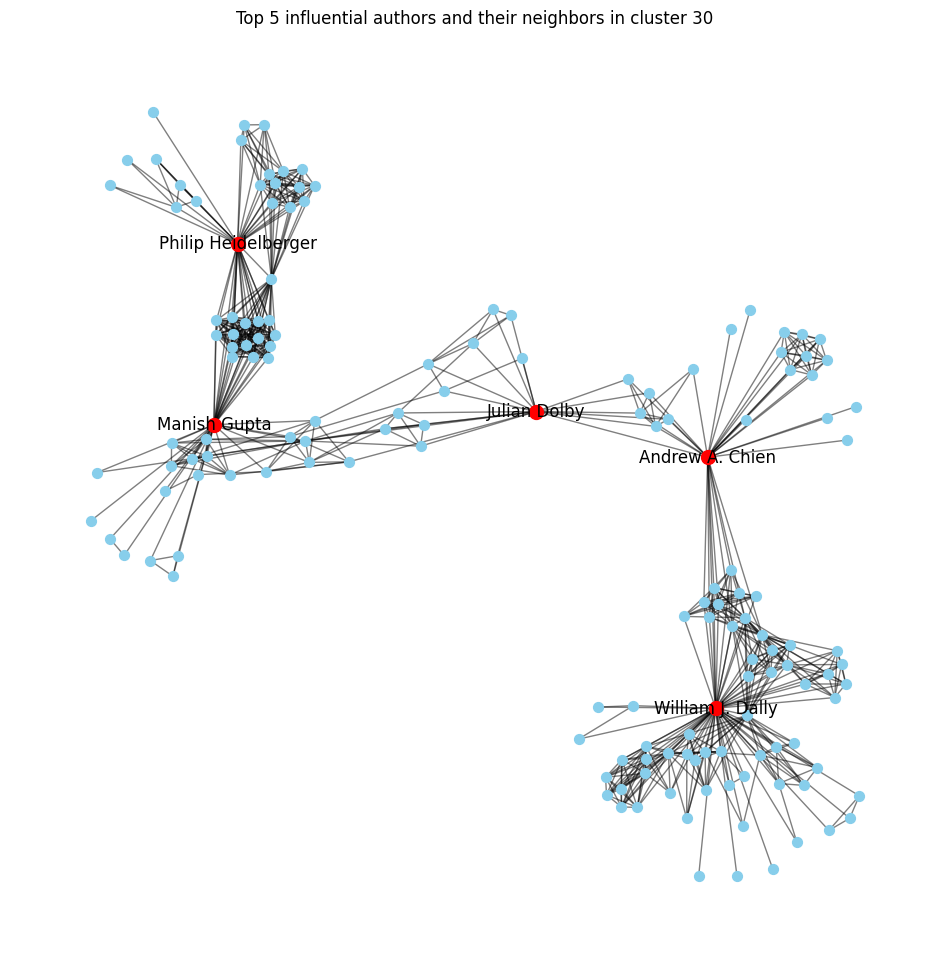

Top 5 influential authors in cluster 30: ['Manish Gupta', 'William J. Dally', 'Andrew A. Chien', 'Julian Dolby', 'Philip Heidelberger']


In [6]:

def find_top_influential_authors(cluster_id, author_network, author_partition, top_n=5, visualize=False):
    """
    Identify the top n influential authors within a specific cluster and optionally visualize the cluster.

    cluster_id: The ID of the cluster to analyze.
    author_network: The full author network graph.
    author_partition: A dictionary mapping authors to their clusters.
    top_n: Number of top influential authors to return.
    visualize: Boolean flag to indicate whether to visualize the network.
    return  A list of top n influential authors in the cluster.
    """
    # Extract the subgraph corresponding to the cluster
    authors_in_cluster = [author for author, cluster in author_partition.items() if cluster == cluster_id]
    subgraph = author_network.subgraph(authors_in_cluster)

    # Compute centrality measures and combine them
    degree_centrality = nx.degree_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    pagerank = nx.pagerank(subgraph)
    combined_scores = {author: (degree_centrality[author] + betweenness_centrality[author] + pagerank[author]) / 3 for author in subgraph.nodes}

    # Sort authors by combined score
    top_authors = sorted(combined_scores, key=combined_scores.get, reverse=True)[:top_n]

    if visualize:
        # Create a subgraph that contains the top influential authors and their neighbors
        neighbors = set()
        for author in top_authors:
            neighbors.update(set(subgraph.neighbors(author)))
        visualization_subgraph = subgraph.subgraph(top_authors + list(neighbors))

        # Visualization
        plt.figure(figsize=(12, 12))
        pos = nx.spring_layout(visualization_subgraph)
        
        # Draw all the nodes and edges with default options
        nx.draw_networkx_edges(visualization_subgraph, pos, alpha=0.5)
        nx.draw_networkx_nodes(visualization_subgraph, pos, nodelist=neighbors, node_color='skyblue', node_size=50)
        
        # Highlight the top authors in red
        nx.draw_networkx_nodes(visualization_subgraph, pos, nodelist=top_authors, node_color='red', node_size=100)
        
        # Labels for the top authors
        top_authors_labels = {author: author for author in top_authors}
        nx.draw_networkx_labels(visualization_subgraph, pos, labels=top_authors_labels, font_size=12, font_color='black')

        plt.title(f"Top {top_n} influential authors and their neighbors in cluster {cluster_id}")
        plt.axis('off')
        plt.savefig(f'visualizations/cluster{cluster_id}_top_influential_authors.png')
        plt.show()

    return top_authors

# Example
cluster_id = 30  # cluster ID
top_influential_authors = find_top_influential_authors(cluster_id, author_network, author_partition, top_n=5, visualize=True)
print(f"Top {len(top_influential_authors)} influential authors in cluster {cluster_id}: {top_influential_authors}")


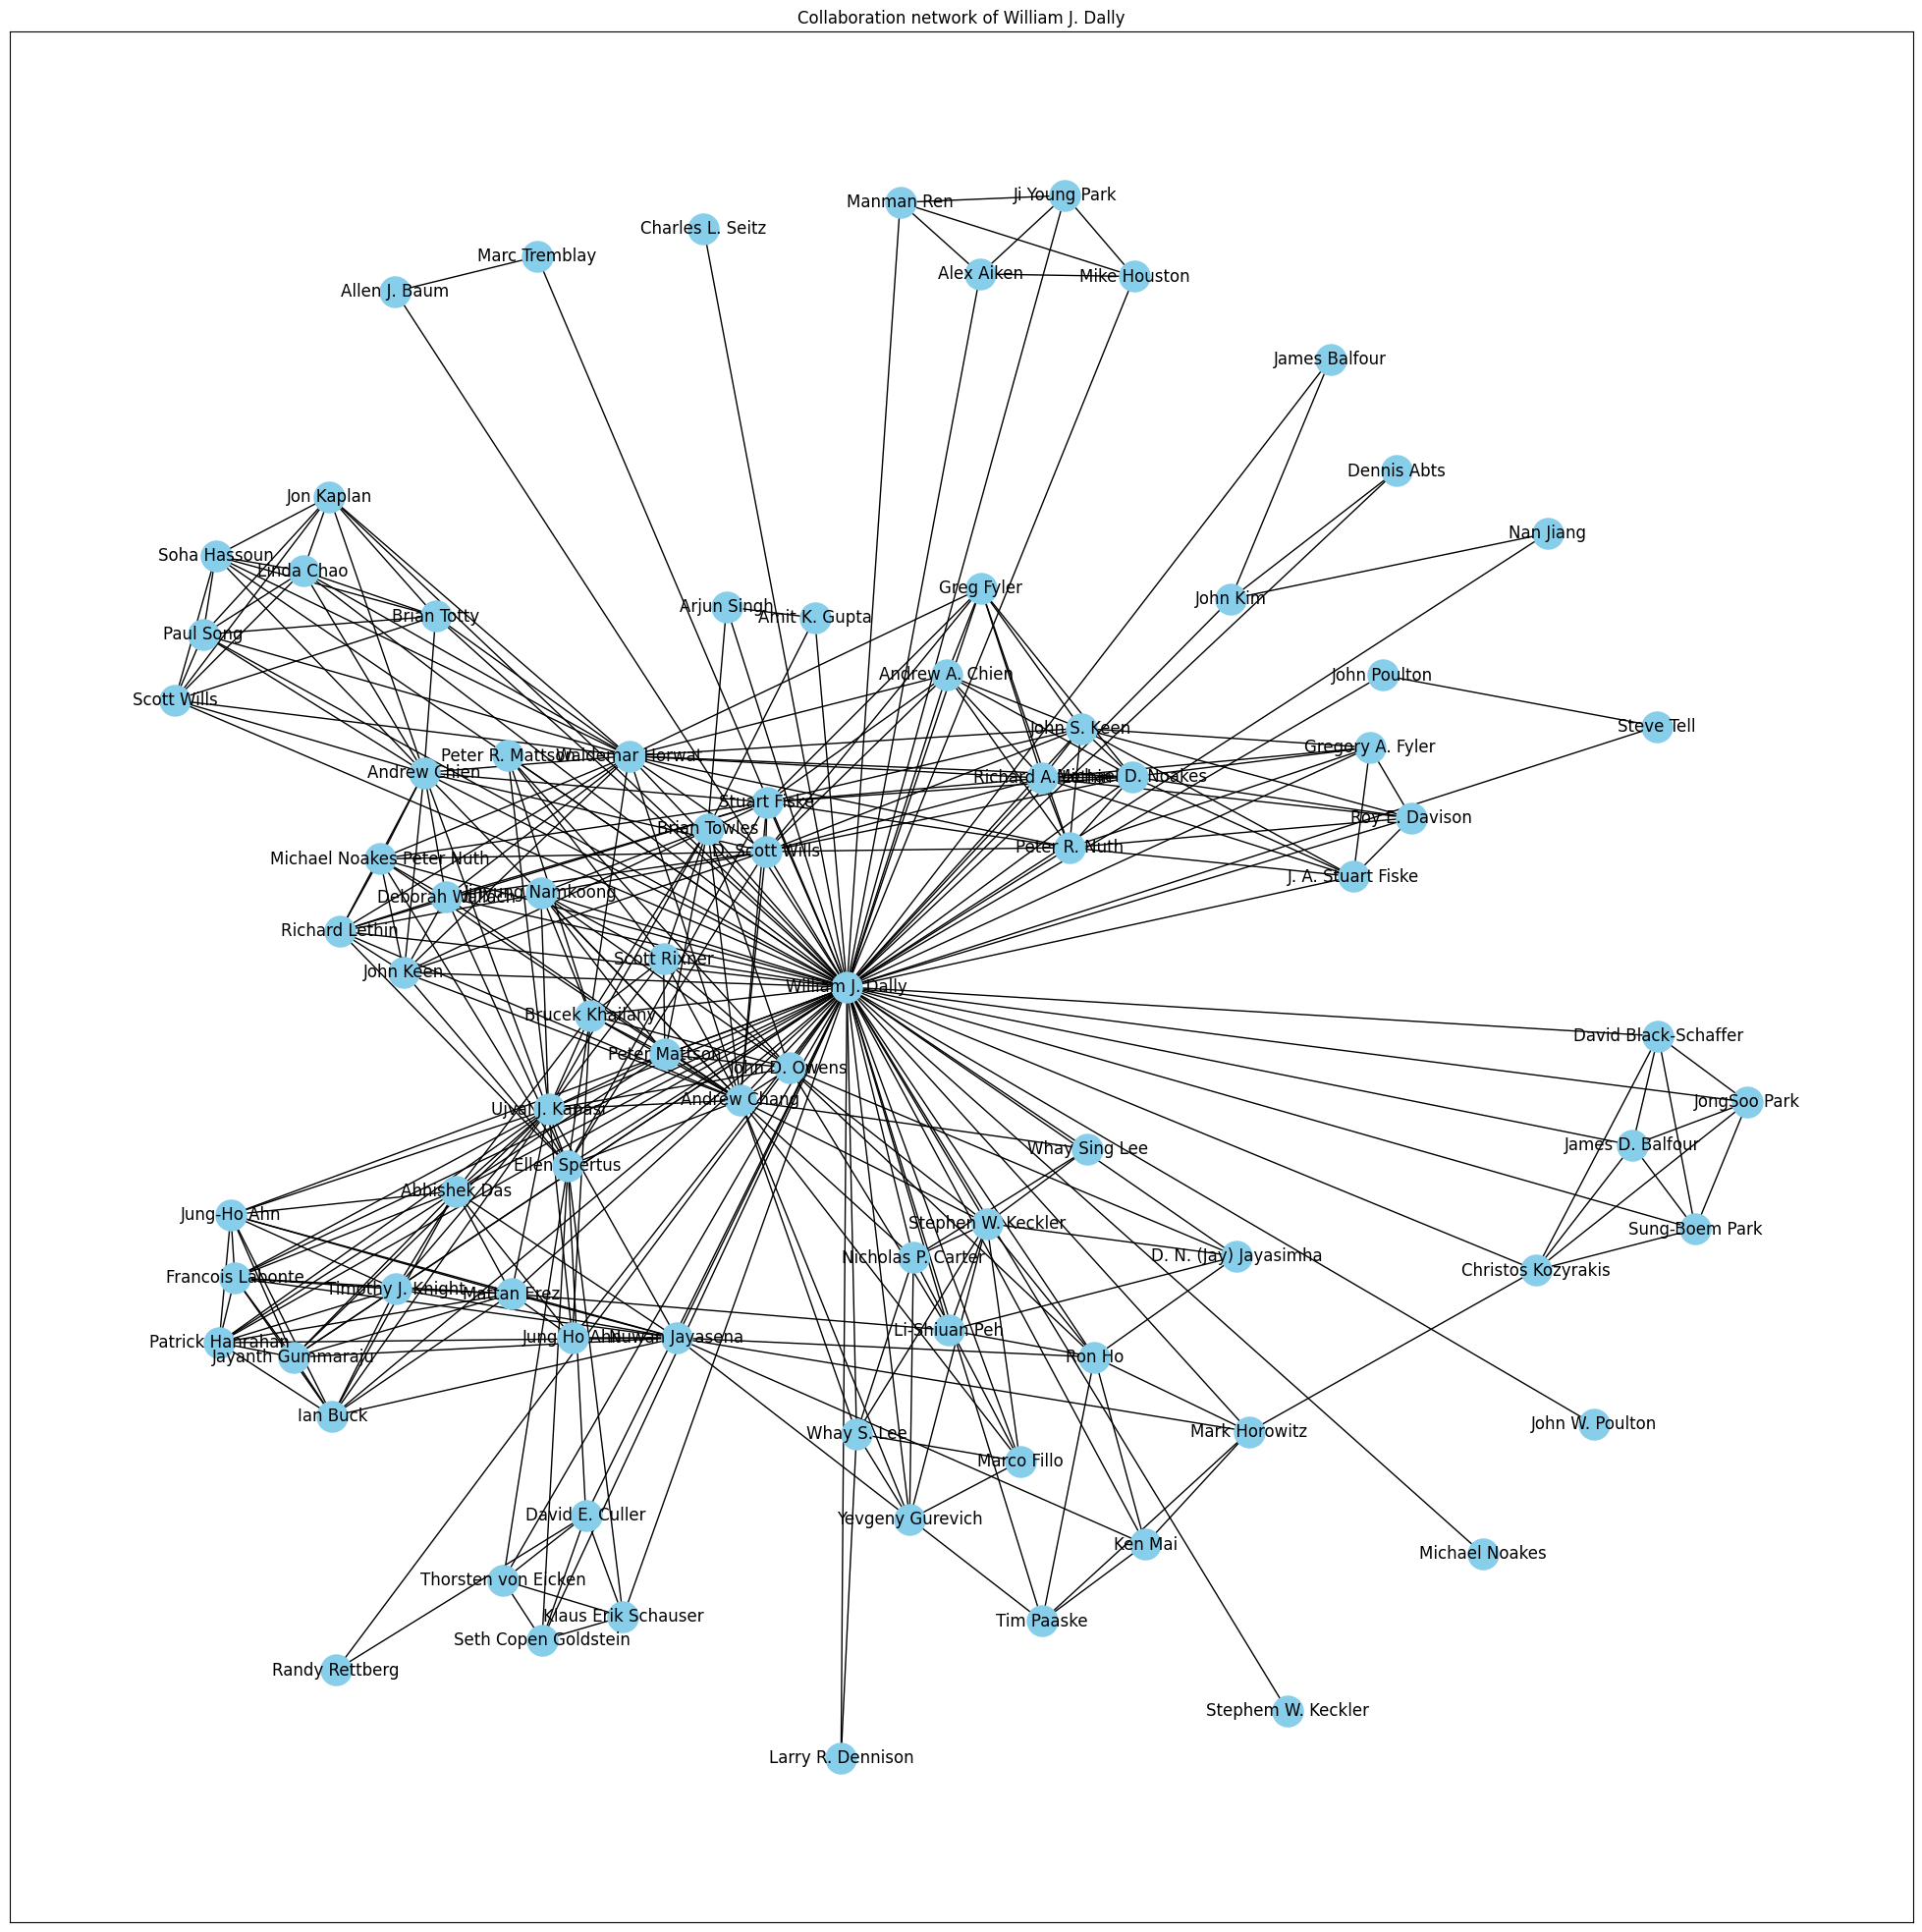

In [23]:
collaborators = get_collaborators(author_network, "William J. Dally", visualize=True, visualize_node_size=2000,fig_size = (25,25))


### LDA Topic Modeling

In [7]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

def lda_topic_modeling(texts, num_topics=5, num_words=5, passes=15, alpha='auto', eta='auto', frequency_filter_thres = 5):
    """
    Apply LDA topic modeling to a list of texts with improved preprocessing and LDA tuning.

    texts: List of documents (titles or abstracts).
    num_topics: Number of topics to identify.
    num_words: Number of words to represent each topic.
    passes: Number of passes through the corpus during training.
    alpha: Hyperparameter affecting topic sparsity.
    eta: Hyperparameter affecting word sparsity.
    frequency_filter_thres: consider vocabs that appear in frequency_filter_thres number of papers
    return: LDA model and dictionary of topics with their representative words.
    """
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Enhanced preprocessing of documents
    processed_texts = [
        [lemmatizer.lemmatize(word) for word in re.findall(r'\b\w+\b', text.lower())
         if word not in stop_words and len(word) > 3]
        for text in texts
    ]
    

    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(processed_texts)
    dictionary.filter_extremes(no_below=frequency_filter_thres, no_above=0.1)  # Filter out too frequent or too rare words
    corpus = [dictionary.doc2bow(text) for text in processed_texts] # Return a list of tuples (token_id, token count)

    # Apply LDA
    try: 
        lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary,
                          passes=passes, alpha=alpha, eta=eta, random_state=42)

        # Evaluate topic coherence
        coherence_model = CoherenceModel(model=lda, texts=processed_texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        print('Coherence Score:', coherence_score)

        # Extract topics
        topics = {i: lda.show_topic(i, topn=num_words) for i in range(num_topics)}
    except:
        lda = []
        topics = dict()
        coherence_score = None
        
    return lda, topics, coherence_score, corpus




#### Example: Cluster 30

In [21]:
chosen_paper_cluster = cluster_papers['30']
lda_model, topics_summary, coherence_score, corpus = lda_topic_modeling(chosen_paper_cluster, num_topics= 20, num_words=10, frequency_filter_thres = 0)
print('Clustering No. 30')
for topic_num, topic_words in topics_summary.items():
    print(f"Topic {topic_num+1}: {topic_words}")

Coherence Score: 0.32756973411547496
Clustering No. 30
Topic 1: [('distributed', 0.008625484), ('communication', 0.008272349), ('node', 0.007832745), ('software', 0.007802685), ('cluster', 0.007551456), ('protocol', 0.0063551622), ('component', 0.00613778), ('resource', 0.005542258), ('multiprocessor', 0.0046521905), ('output', 0.0045495047)]
Topic 2: [('compiler', 0.0133240735), ('optimization', 0.010635415), ('image', 0.007073962), ('branch', 0.0067651453), ('power', 0.0063237906), ('efficiency', 0.0062364903), ('error', 0.0060247234), ('communication', 0.0055148965), ('hardware', 0.0054578586), ('information', 0.005306398)]
Topic 3: [('cache', 0.019846087), ('chip', 0.009234212), ('access', 0.008609853), ('latency', 0.0071839103), ('bandwidth', 0.007031691), ('compilation', 0.0068161096), ('different', 0.0061425273), ('pattern', 0.0060477536), ('server', 0.0055975583), ('hardware', 0.005577191)]
Topic 4: [('object', 0.04842893), ('type', 0.020643208), ('oriented', 0.012708338), ('pr

In [135]:
# Example cluster 5
chosen_paper_cluster = cluster_papers[5]
lda_model, topics_summary, coherence_score, corpus = lda_topic_modeling(chosen_paper_cluster, num_topics= 30, num_words=10, frequency_filter_thres = 0)
print(coherence_score)
for topic_num, topic_words in topics_summary.items():
    print(f"Topic {topic_num}: {topic_words}")

Coherence Score: 0.34835998812043534
0.34835998812043534
Topic 0: [('agent', 0.02246764), ('level', 0.013243577), ('language', 0.012867011), ('embedded', 0.012005798), ('architecture', 0.011973434), ('correlation', 0.009493349), ('protocol', 0.009324499), ('operation', 0.009202202), ('software', 0.008865854), ('card', 0.008303928)]
Topic 1: [('event', 0.015257438), ('research', 0.013033016), ('knowledge', 0.010338411), ('field', 0.009618797), ('question', 0.008882233), ('book', 0.008693157), ('multimedia', 0.008682226), ('mining', 0.00841812), ('standard', 0.008417297), ('review', 0.0075275013)]
Topic 2: [('graph', 0.06237186), ('curve', 0.019287294), ('kernel', 0.01656777), ('function', 0.015710797), ('path', 0.015405057), ('reuse', 0.012771422), ('number', 0.011168499), ('entropy', 0.010647714), ('filter', 0.010603385), ('rational', 0.00918802)]
Topic 3: [('left', 0.011178307), ('action', 0.010974975), ('human', 0.010407668), ('brain', 0.010137013), ('activity', 0.009062185), ('respo

In [8]:
def visualize_topics(lda_model, num_words=10):
    """
    Visualize the word distribution of each topic in an LDA model.

    lda_model: Trained LDA model.
    num_words: Number of top words to include in the visualization for each topic.
    """
    for topic_idx, topic in enumerate(lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)):
        plt.figure(figsize=(15, 4))
        topic_words, weights = zip(*topic[1])
        
        plt.bar(range(num_words), weights, align='center')
        plt.xticks(range(num_words), topic_words, rotation='horizontal')
        plt.title(f'Topic {topic_idx}')
        plt.xlabel('Words')
        plt.ylabel('Weights')
        plt.show()



In [ ]:
def get_authors_by_titles(df, paper_titles):
    """
    Return a list of authors for each paper title in the given list.

    :param df: DataFrame containing columns 'title' and 'authors'.
    :param paper_titles: List of paper titles.
    :return: List of lists, where each inner list contains the authors of the corresponding paper.
    """
    authors_lists = []
    for title in paper_titles:
        # Find the authors for the given title
        authors = df[df['title'] == title]['authors'].tolist()
        
        # Appending the authors list to the main list
        # It assumes that each title corresponds to one row in the DataFrame
        # If a title is not found, an empty list is appended
        authors_lists.append(authors[0] if authors else [])

    return authors_lists

# Example 
paper_titles = list(set(cluster_papers_title['5']))
paper_authors = get_authors_by_titles(df, paper_titles)



In [18]:
thres = 5000
cluster_paper_large = {index:paper for index, paper in cluster_papers.items() if len(paper) > thres}
print(f"Number of large clusters (> {thres} papers):", len(cluster_paper_large.items()))


Number of large clusters (> 5000 papers): 19


### Topics of Large Clusters

In [19]:
# set a threshold for large size clustering and small clustering
from collections import defaultdict
thres = 15000
cluster_paper_large = {index:paper for index, paper in cluster_papers.items() if len(paper) > thres}
print(f"Number of large clusters (> {thres} papers):", len(cluster_paper_large.items()))
cluster_paper_small = {index:paper for index, paper in cluster_papers.items() if len(paper) <= thres}
print(f"Number of small clusters (<= {thres} papers):", len(cluster_paper_small.items()))

topics_of_all_large_clustering = defaultdict(dict)
for idx, cluster_paper in cluster_paper_large.items():
    lda_model, topics_summary, coherence_score, corpus = lda_topic_modeling(cluster_paper, num_topics= int(len(cluster_paper)/100), num_words=20, frequency_filter_thres = 0)
    topics_of_all_large_clustering[idx]["topics_dict"] = topics_summary
    topics_of_all_large_clustering[idx]["lda_model"] = lda_model
    topics_of_all_large_clustering[idx]["coherence score"] = coherence_score
    topics_of_all_large_clustering[idx]["corpus"] = corpus




Number of large clusters (> 15000 papers): 5
Number of small clusters (<= 15000 papers): 52500


In [31]:
# Saving with pickle
import pickle
with open('Results/topics_of_all_large_clustering.pkl', 'wb') as f:
    pickle.dump(topics_of_all_large_clustering, f)

In [10]:
# Loading with pickle
with open('Results/topics_of_all_large_clustering.pkl', 'rb') as f:
    topics_of_all_large_clustering = pickle.load(f)   

#### Visualize Topics in Large Clusters

In [53]:
print(len(topics_of_all_large_clustering.keys()))
for idx, v in topics_of_all_large_clustering.items():
    print(f"Cluster {idx}")
    for topic,keywords in v['topics_dict'].items():
        print(f'Topic {topic}:', keywords)
    print()

5
Cluster 4
Topic 0: [('image', 0.31120312), ('content', 0.19818933), ('retrieval', 0.15476918), ('color', 0.029540988), ('proposed', 0.01612946), ('indexing', 0.014964532), ('formulated', 0.014461733), ('similar', 0.013265129), ('latest', 0.010549846), ('enormous', 0.009097124), ('searching', 0.009048313), ('similarity', 0.008138532), ('novel', 0.0073744687), ('wavelet', 0.0071997545), ('chase', 0.0069442764), ('experimental', 0.006537072), ('ultimate', 0.006348167), ('dataflow', 0.005296919), ('presented', 0.005130403), ('essential', 0.005018822)]
Topic 1: [('dependency', 0.18677452), ('generating', 0.09841239), ('attention', 0.057696883), ('column', 0.056214932), ('consistent', 0.051338084), ('completeness', 0.04560045), ('received', 0.031564217), ('cardinality', 0.028657265), ('complement', 0.021645203), ('given', 0.019498467), ('differs', 0.017953737), ('different', 0.017796738), ('inconsistency', 0.016053362), ('repair', 0.014172518), ('agreement', 0.013657028), ('tgds', 0.013054

### Research Group Finding

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_similarity(input_words, topic_keywords, top_n=5):
    """
    Compute the similarity between input words and topic keywords.

    input_words: List of words or phrases relevant to a research topic.
    topic_keywords: List of lists containing topic keywords.
    top_n: Number of top similar topics to return.
    List of top n similar topics (indices).
    """
    # Combine input words and topic keywords into a single list
    combined_texts = [' '.join(input_words)] + [' '.join(keywords) for keywords in topic_keywords]

    # Use TF-IDF to vectorize the words
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined_texts)

    # Compute cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])
    cosine_sim = cosine_sim.flatten()

    # Get top n similar topics
    top_topics_indices = np.argsort(cosine_sim)[-top_n:][::-1]

    return top_topics_indices

# Example 
# input_words = ['neural network', 'deep learning']
# topic_keywords = [['algorithm', 'data', 'model'], ['neural', 'learning', 'network']]  # Example topic keywords
# similar_topics = compute_similarity(input_words, topic_keywords)
# print("Top Similar Topics:", similar_topics)


def find_relevant_clusters_by_similarity(input_words, topic_keywords, top_n=5):
    """
    Find the top n clusters whose topics are most similar to the input words.

    input_words: List of words or phrases relevant to a research topic.
    topics_summary: Dictionary of clusters and their associated topic indices.
    topic_keywords {cluster_idx: {topic1:[(word1, 0.1), ...], topic2: [(,)], ...}}
    corpus: Corpus used for LDA model.
    top_n: Number of top clusters to return.
    List of top n relevant cluster IDs with relevant topics stored in dict cluster id: list of topics
    """
    relevant_clusters = dict()
    for cluster_idx in topic_keywords.keys():
        cluster_keyword = topic_keywords[cluster_idx]
        
        topic_keywords_list = list( list(word for word,score in keywords) for topic_idx, keywords in cluster_keyword['topics_dict'].items())
        # Compute similarity
        top_topics_indices = compute_similarity(input_words, topic_keywords_list, top_n)
        relevant_clusters[cluster_idx] = top_topics_indices

    return relevant_clusters




In [90]:
# input_words is words or topics you want to search for
input_words = ['parallel computing']

relevant_clusters = find_relevant_clusters_by_similarity(input_words, topics_of_all_large_clustering, top_n=3)
for cluster_id in relevant_clusters:
    print(f"Cluster {cluster_id}:", relevant_clusters[cluster_id])
    for topic_idx in relevant_clusters[cluster_id]:
        print(f"Topic {topic_idx}:", topics_of_all_large_clustering[cluster_id]['topics_dict'][topic_idx])
    print()


Cluster 4: [  3 120 107]
Topic 3: [('parallel', 0.27954572), ('shared', 0.13152194), ('concurrent', 0.050784595), ('implementation', 0.042818435), ('production', 0.042012755), ('sorting', 0.03641785), ('machine', 0.029710682), ('balanced', 0.028949697), ('priority', 0.027879365), ('execution', 0.026822735), ('switch', 0.021393059), ('percent', 0.017757228), ('usability', 0.016644202), ('passing', 0.016369963), ('similarly', 0.012046506), ('floating', 0.009492587), ('accessibility', 0.008761708), ('serve', 0.008461918), ('sgml', 0.007267038), ('calibration', 0.0071303383)]
Topic 120: [('server', 0.17313547), ('client', 0.10342349), ('computing', 0.08753811), ('heterogeneous', 0.061311107), ('grid', 0.047039773), ('pervasive', 0.022868484), ('functionality', 0.021041352), ('architecture', 0.019951861), ('available', 0.018989997), ('highly', 0.017165106), ('request', 0.016850771), ('provide', 0.01655784), ('accessing', 0.014043382), ('access', 0.011599697), ('existing', 0.010156881), ('ht

In [89]:
input_words = ['business', 'market']

relevant_clusters = find_relevant_clusters_by_similarity(input_words, topics_of_all_large_clustering, top_n=3)
for cluster_id in relevant_clusters:
    print(f"Cluster {cluster_id}:", relevant_clusters[cluster_id])
    for topic_idx in relevant_clusters[cluster_id]:
        print(f"Topic {topic_idx}:", topics_of_all_large_clustering[cluster_id]['topics_dict'][topic_idx])
    print()


Cluster 4: [ 88  40 182]
Topic 88: [('process', 0.22623886), ('component', 0.1246594), ('modeling', 0.08166294), ('business', 0.07577281), ('enterprise', 0.040409252), ('different', 0.0138326995), ('complex', 0.013825854), ('support', 0.01073106), ('often', 0.009926169), ('important', 0.009838871), ('autonomic', 0.009149692), ('need', 0.008119349), ('reuse', 0.008021424), ('within', 0.007319398), ('enable', 0.006787072), ('therefore', 0.006226291), ('lifecycle', 0.0062099504), ('critical', 0.0061505875), ('effort', 0.0060874345), ('provides', 0.005956832)]
Topic 40: [('ontology', 0.14679009), ('description', 0.12872128), ('repository', 0.06550146), ('market', 0.04769666), ('describing', 0.041076984), ('different', 0.028874652), ('taxonomy', 0.024700163), ('measuring', 0.024507457), ('describe', 0.023687426), ('provide', 0.020055354), ('semantic', 0.017806748), ('adapted', 0.016494075), ('propose', 0.015824294), ('term', 0.015240212), ('automatically', 0.013754516), ('usually', 0.012522

In [93]:
input_words = ['image', "video", 'pixels', 'resolution', 'media']

relevant_clusters = find_relevant_clusters_by_similarity(input_words, topics_of_all_large_clustering, top_n=3)
for cluster_id in relevant_clusters:
    print(f"Cluster {cluster_id}:", relevant_clusters[cluster_id])
    for topic_idx in relevant_clusters[cluster_id]:
        print(f"Topic {topic_idx}:", topics_of_all_large_clustering[cluster_id]['topics_dict'][topic_idx])
    print()


Cluster 4: [  0 105 169]
Topic 0: [('image', 0.31120312), ('content', 0.19818933), ('retrieval', 0.15476918), ('color', 0.029540988), ('proposed', 0.01612946), ('indexing', 0.014964532), ('formulated', 0.014461733), ('similar', 0.013265129), ('latest', 0.010549846), ('enormous', 0.009097124), ('searching', 0.009048313), ('similarity', 0.008138532), ('novel', 0.0073744687), ('wavelet', 0.0071997545), ('chase', 0.0069442764), ('experimental', 0.006537072), ('ultimate', 0.006348167), ('dataflow', 0.005296919), ('presented', 0.005130403), ('essential', 0.005018822)]
Topic 105: [('source', 0.26059133), ('integration', 0.14284767), ('integrating', 0.04233269), ('uncertainty', 0.039687995), ('expert', 0.039374884), ('feedback', 0.03885892), ('resolution', 0.03453109), ('integrated', 0.02851542), ('interpretation', 0.02568574), ('different', 0.022851398), ('multiple', 0.020175086), ('conflict', 0.01949285), ('describe', 0.015291185), ('provide', 0.013554732), ('regarding', 0.011274037), ('trad

### Top Influential Researchers in 5 Large Clusters

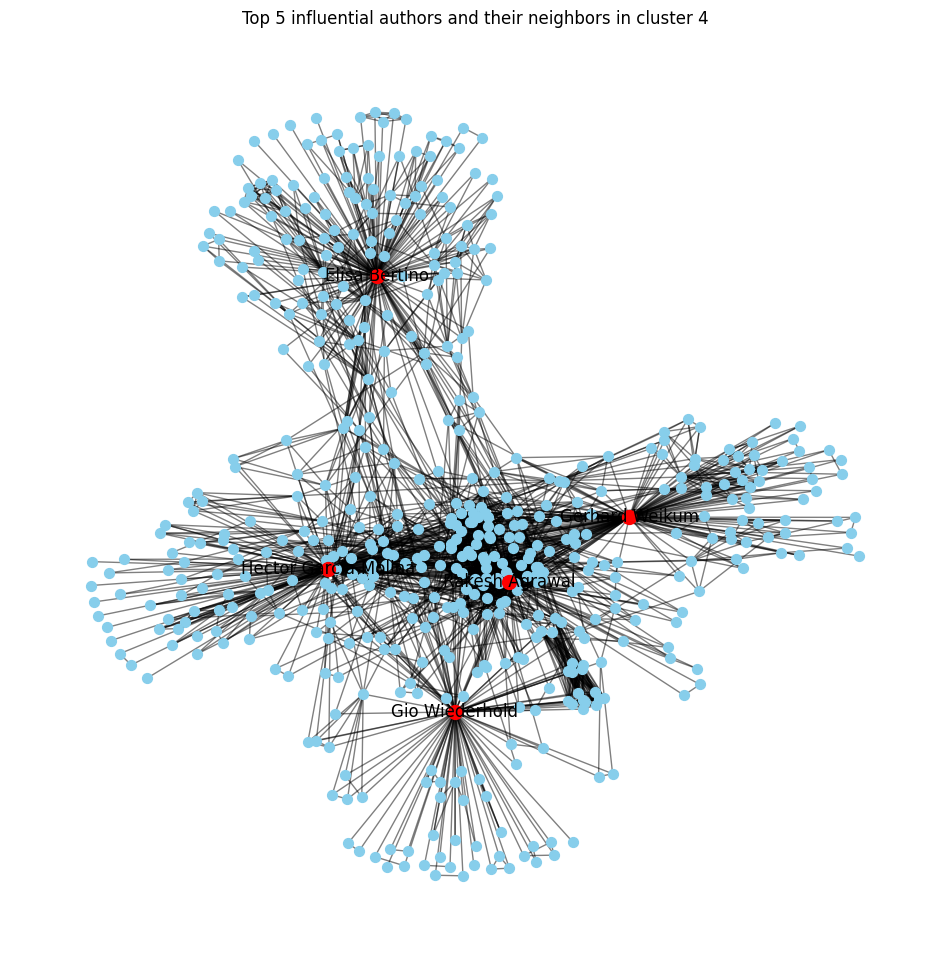

Top 5 influential authors in cluster 4: ['Elisa Bertino', 'Hector Garcia-Molina', 'Rakesh Agrawal', 'Gerhard Weikum', 'Gio Wiederhold']


KeyboardInterrupt: 

In [95]:

large_cluster_ids = list(topics_of_all_large_clustering.keys())
for id in large_cluster_ids:    
    top_influential_authors = find_top_influential_authors(int(id), author_network, author_partition, top_n=5, visualize=True)
    print(f"Top {len(top_influential_authors)} influential authors in cluster {id}: {top_influential_authors}")


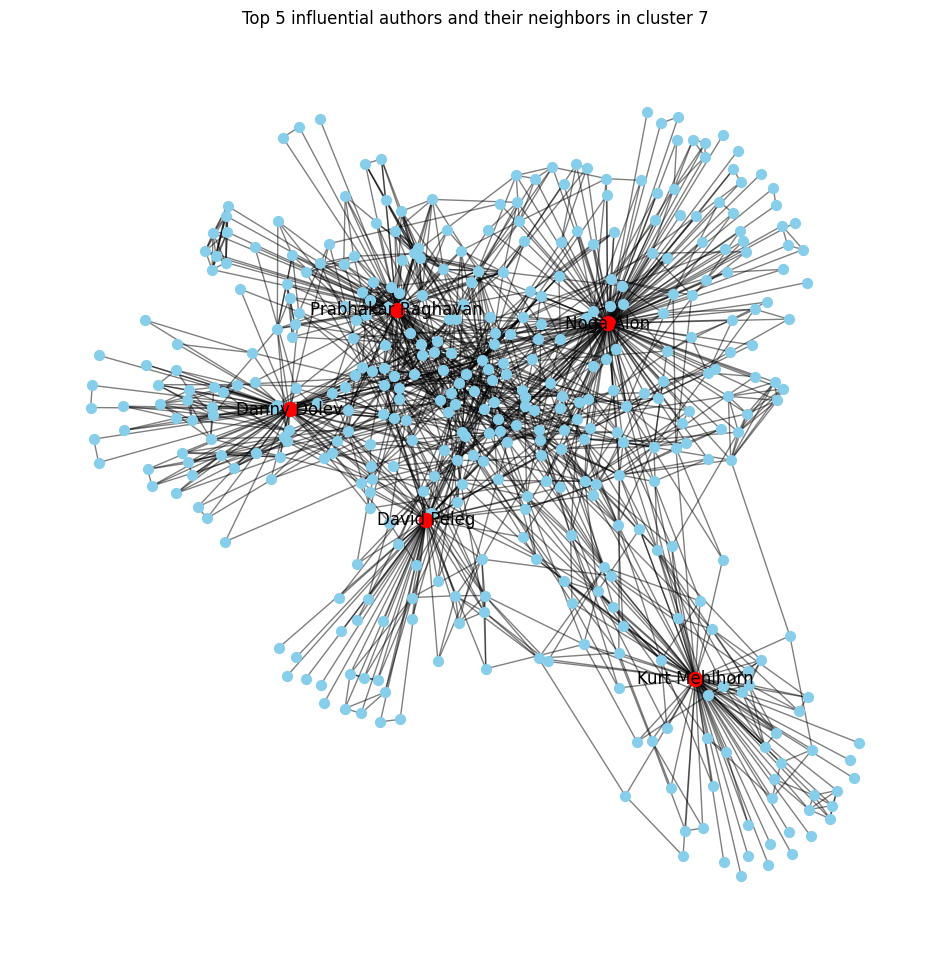

Top 5 influential authors in cluster 7: ['Noga Alon', 'Kurt Mehlhorn', 'Prabhakar Raghavan', 'Danny Dolev', 'David Peleg']


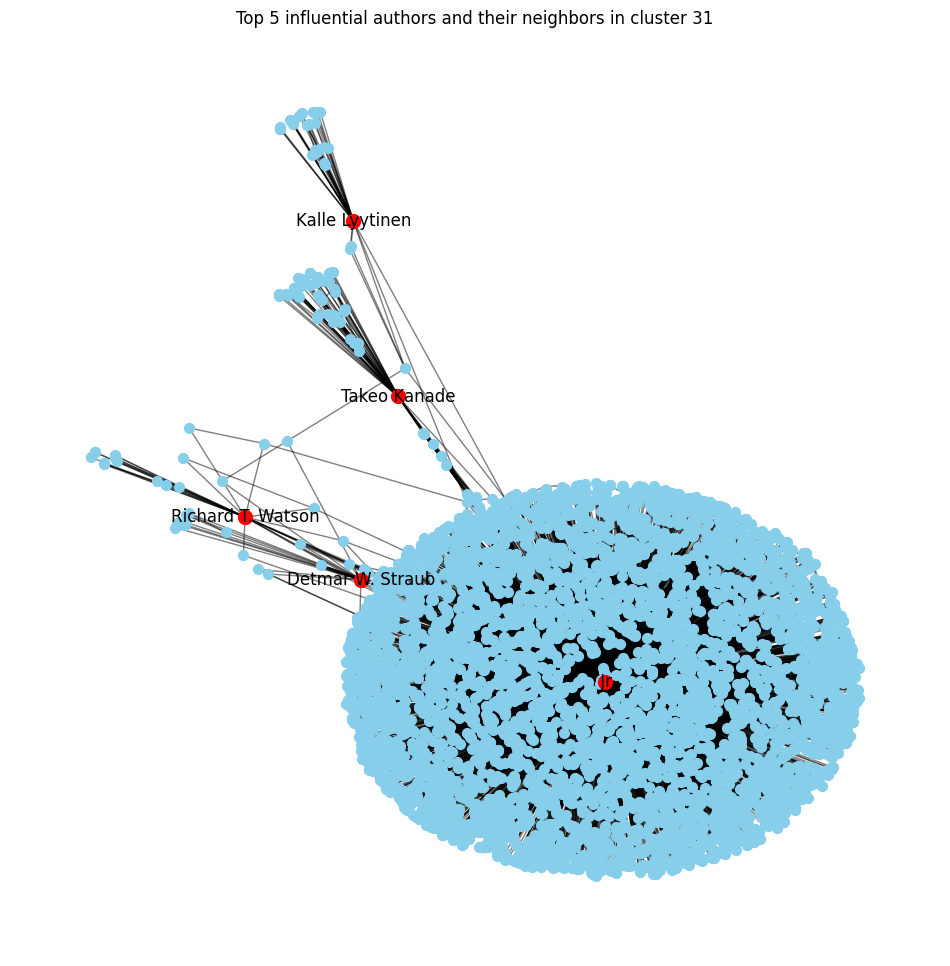

Top 5 influential authors in cluster 31: [' Jr.', 'Kalle Lyytinen', 'Detmar W. Straub', 'Takeo Kanade', 'Richard T. Watson']


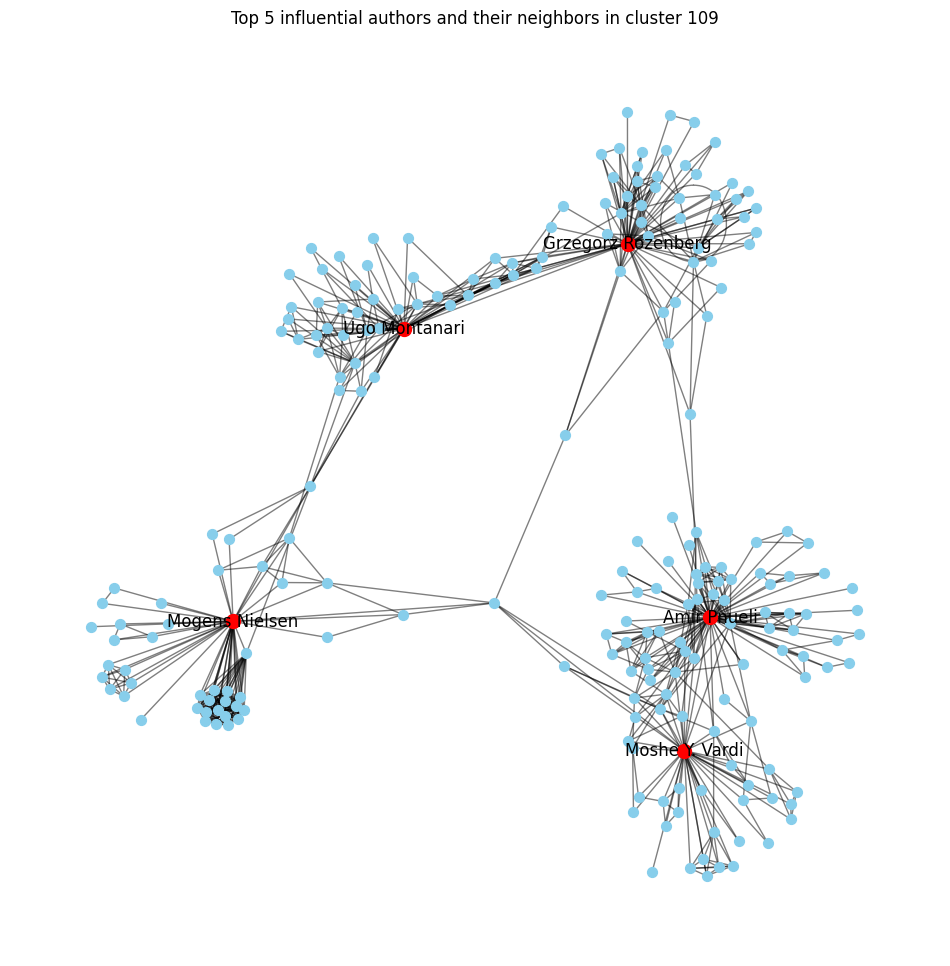

Top 5 influential authors in cluster 109: ['Grzegorz Rozenberg', 'Mogens Nielsen', 'Amir Pnueli', 'Ugo Montanari', 'Moshe Y. Vardi']


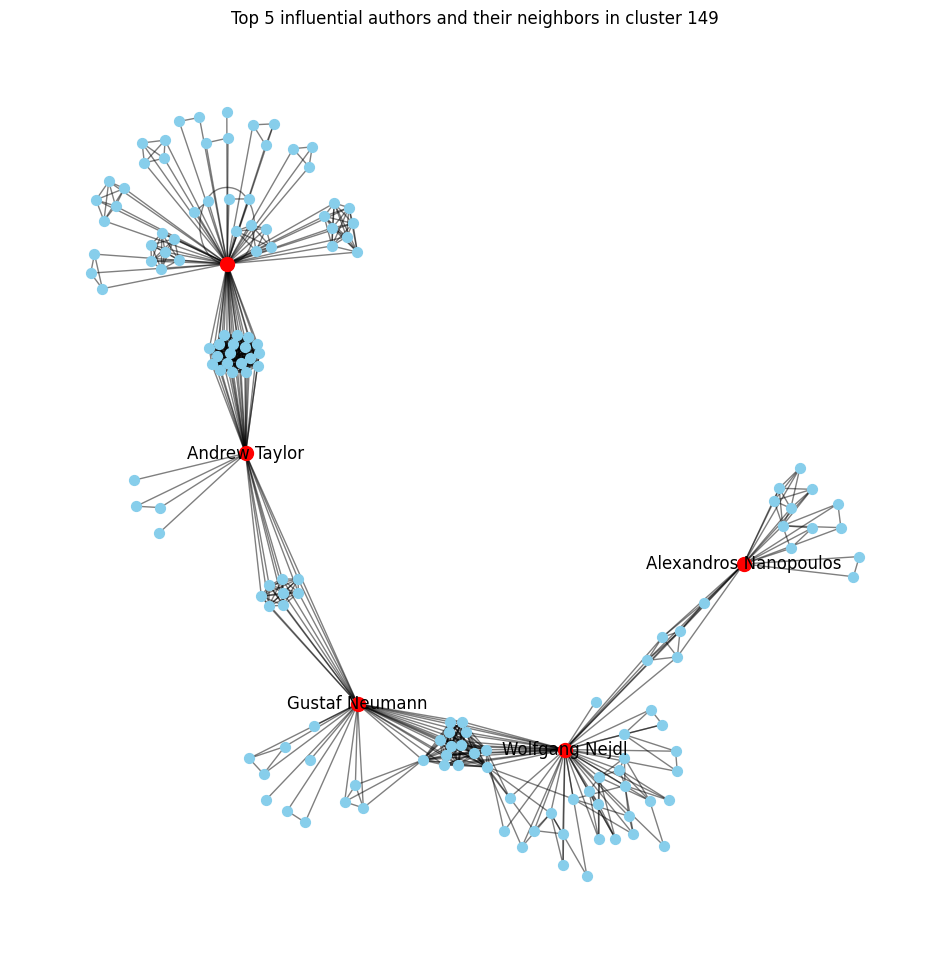

Top 5 influential authors in cluster 149: ['Wolfgang Nejdl', '', 'Gustaf Neumann', 'Andrew Taylor', 'Alexandros Nanopoulos']
